## Shorten the names of superoperator files

In [157]:
import os
import shutil

folder = r'C:\Users\ssingh8\OneDrive - Delft University of Technology\Research\[PROJECTS]\Emission based direct schemes\simulations_data\1_basic_first_simulation\0_first_rates_at_inf_cutoff\New folder'

def copy_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith("merged.csv"):
            source = os.path.join(directory, filename)
            destination = os.path.join(directory, "copy_" + filename)
            shutil.copy2(source, destination)

# for EM Direct WT4
def rename_files(directory):
    for filename in os.listdir(directory):
        if filename.startswith("copy_"):
            bell_type = filename[filename.find("bell_pair_type-")+len("bell_pair_type-"):filename.rfind("_network_")]
            nn_type =  filename[filename.find("network_noise_type-")+len("network_noise_type-"):filename.rfind("_p_g")]
            set_parameters = filename[filename.find("hc_direct_ghz_node-")+len("hc_direct_ghz_node-"):filename.rfind("_bell_pair_type")]
            pg_val = float(filename[filename.find("p_g-")+len("p_g-"):filename.rfind("_p_m")])
            new_filename = filename.replace(filename, f"copy_{set_parameters}_bell_{bell_type}_nntype_{nn_type}_p_g-{pg_val}_p_m_.csv")
            source = os.path.join(directory, filename)
            destination = os.path.join(directory, new_filename)
            os.rename(source, destination)


copy_files(folder)
rename_files(folder)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\ssingh8\\OneDrive - Delft University of Technology\\Research\\[PROJECTS]\\Emission based direct schemes\\simulations_data\\1_basic_first_simulation\\0_first_rates_at_inf_cutoff\\New folder'

# Comparison of various direct emission protocols

In [ ]:
from circuit_simulation.circuit_simulator import QuantumCircuit
# Set the Bell-state parameters
bell_pair_parameters = {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":0.02}

# Coherence parameters
# NeutralAtom1 (Set-3)
# T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf
# No-decoherence
# T2n_idle=np.inf,T1n_idle=np.inf,T2n_link=np.inf,T1n_link=np.inf,T2e_idle=np.inf,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf


## Bright state parameter influence

alpha:0.0101
*** GHZ state fidelity of Raw state is 0.9131257083019457.***
*** Success probability of Raw state is 6.396561270228503e-05.***
*** GHZ state fidelity of DC direct emission state is 0.9344124207297275.***
*** Success probability of DC direct emission state is 2.728556639296327e-06.***
*** GHZ state fidelity of the Basic protocol state is 0.6666624628371395.***
*** Success probability of the Basic protocol state is (3.997845750411486e-06+0j).***
*** GHZ state fidelity of the W-state protocol state is 0.6666624859433206.***
*** Success probability of the W-state protocol state is (7.967111116386678e-06+0j).***
*** GHZ state fidelity of the Bell distillation protocol state is 0.6666624697285248.***
*** Success probability of the Bell distillation protocol state is (1.5878739303438706e-05+0j).***
alpha:0.0601
*** GHZ state fidelity of Raw state is 0.8764513746755458.***
*** Success probability of Raw state is 0.002216352829676099.***
*** GHZ state fidelity of DC direct emissio

c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


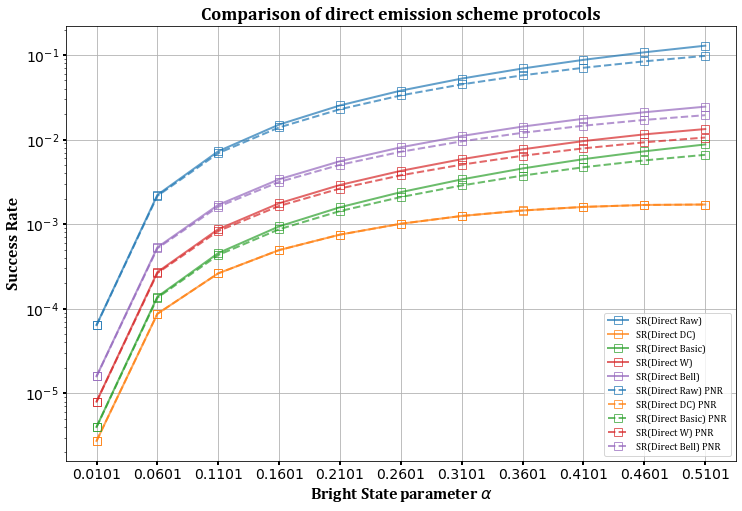

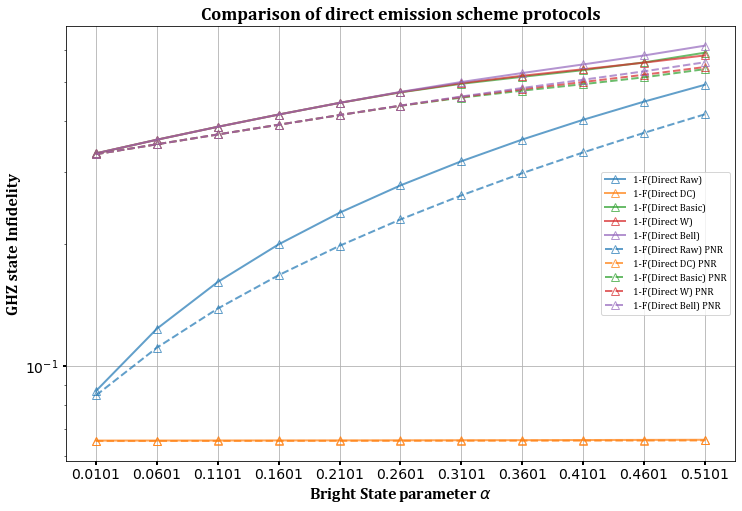

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from circuit_simulation.circuit_simulator import QuantumCircuit

# Bright State parameter alpha
alpha = np.arange(0.0101, 0.55, 0.05)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot the curves with specified markers and colors
raw_p = []
raw_inf = []
dc_state_p = []
dc_state_inf = []
basic_state_p = []
basic_state_inf = []
w_state_p = []
w_state_inf = []
bell_distilled_state_p = []
bell_distilled_state_inf = []

pnr_raw_p = []
pnr_raw_inf = []
pnr_dc_state_p = []
pnr_dc_state_inf = []
pnr_basic_state_p = []
pnr_basic_state_inf = []
pnr_w_state_p = []
pnr_w_state_inf = []
pnr_bell_distilled_state_p = []
pnr_bell_distilled_state_inf = []

for alpha_val in alpha:
    print(f"alpha:{alpha_val}")
    bell_pair_parameters = {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":alpha_val}
    raw_state_qc = QuantumCircuit(1,network_noise_type=100, bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    raw_p.append(raw_state_qc.p_link)
    raw_inf.append(1-raw_state_qc.F_link)

    dc_state_qc = QuantumCircuit(1,network_noise_type=101, bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    dc_state_p.append(dc_state_qc.p_link)
    dc_state_inf.append(1-dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(1,network_noise_type=103, bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    basic_state_p.append(basic_distilled_state_qc.p_link)
    basic_state_inf.append(1-basic_distilled_state_qc.F_link)

    w_distilled_state_qc = QuantumCircuit(1,network_noise_type=104, bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    w_state_p.append(w_distilled_state_qc.p_link)
    w_state_inf.append(1-w_distilled_state_qc.F_link)

    bell_distilled_state_qc = QuantumCircuit(1,network_noise_type=102, bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    bell_distilled_state_p.append(bell_distilled_state_qc.p_link)
    bell_distilled_state_inf.append(1-bell_distilled_state_qc.F_link)

for alpha_val in alpha:
    print(f"alpha:{alpha_val}")
    bell_pair_parameters = {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":alpha_val}
    raw_state_qc = QuantumCircuit(1,network_noise_type=100, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    pnr_raw_p.append(raw_state_qc.p_link)
    pnr_raw_inf.append(1-raw_state_qc.F_link)

    dc_state_qc = QuantumCircuit(1,network_noise_type=101, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    pnr_dc_state_p.append(dc_state_qc.p_link)
    pnr_dc_state_inf.append(1-dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(1,network_noise_type=103, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    pnr_basic_state_p.append(basic_distilled_state_qc.p_link)
    pnr_basic_state_inf.append(1-basic_distilled_state_qc.F_link)

    w_distilled_state_qc = QuantumCircuit(1,network_noise_type=104, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    pnr_w_state_p.append(w_distilled_state_qc.p_link)
    pnr_w_state_inf.append(1-w_distilled_state_qc.F_link)

    bell_distilled_state_qc = QuantumCircuit(1,network_noise_type=102, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    pnr_bell_distilled_state_p.append(bell_distilled_state_qc.p_link)
    pnr_bell_distilled_state_inf.append(1-bell_distilled_state_qc.F_link)

ax.plot(alpha, raw_p, marker='s', color='#1f77b4', label='SR(Direct Raw)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax.plot(alpha, dc_state_p, marker='s', color='#ff7f0e', label='SR(Direct DC)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax.plot(alpha, basic_state_p, marker='s', color='#2ca02c', label='SR(Direct Basic)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax.plot(alpha, w_state_p, marker='s', color='#d62728', label='SR(Direct W)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax.plot(alpha, bell_distilled_state_p, marker='s', color='#9467bd', label='SR(Direct Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple

ax.plot(alpha, pnr_raw_p, marker='s', color='#1f77b4', label='SR(Direct Raw) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax.plot(alpha, pnr_dc_state_p, marker='s', color='#ff7f0e', label='SR(Direct DC) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax.plot(alpha, pnr_basic_state_p, marker='s', color='#2ca02c', label='SR(Direct Basic) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax.plot(alpha, pnr_w_state_p, marker='s', color='#d62728', label='SR(Direct W) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax.plot(alpha, pnr_bell_distilled_state_p, marker='s', color='#9467bd', label='SR(Direct Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple

# Enable grid
ax.grid(True)

# Set y-axis to log scale
ax.set_yscale('log')

# Set bold axis ticks and labels
ax.set_xticks(alpha)
# ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax.set_xlabel(r'Bright State parameter $\alpha$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax.set_ylabel('Success Rate', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax.set_title('Comparison of direct emission scheme protocols', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

## INFIDELITY PLOTTING

fig_2, ax_2 = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig_2.patch.set_facecolor('white')
ax_2.set_facecolor('white')

# Filter out nan values
valid_indices = ~np.isnan(raw_inf) & ~np.isnan(dc_state_inf) & ~np.isnan(basic_state_inf) & ~np.isnan(w_state_inf) & ~np.isnan(bell_distilled_state_inf)
alpha_filtered = alpha[valid_indices]
raw_inf_filtered = np.array(raw_inf)[valid_indices]
dc_state_inf_filtered = np.array(dc_state_inf)[valid_indices]
basic_state_inf_filtered = np.array(basic_state_inf)[valid_indices]
w_state_inf_filtered = np.array(w_state_inf)[valid_indices]
bell_distilled_state_inf_filtered = np.array(bell_distilled_state_inf)[valid_indices]

valid_indices_pnr = ~np.isnan(pnr_raw_inf) & ~np.isnan(pnr_dc_state_inf) & ~np.isnan(pnr_basic_state_inf) & ~np.isnan(pnr_w_state_inf) & ~np.isnan(pnr_bell_distilled_state_inf)
alpha_filtered_pnr = alpha[valid_indices_pnr]
pnr_raw_inf_filtered = np.array(pnr_raw_inf)[valid_indices_pnr]
pnr_dc_state_inf_filtered = np.array(pnr_dc_state_inf)[valid_indices_pnr]
pnr_basic_state_inf_filtered = np.array(pnr_basic_state_inf)[valid_indices_pnr]
pnr_w_state_inf_filtered = np.array(pnr_w_state_inf)[valid_indices_pnr]
pnr_bell_distilled_state_inf_filtered = np.array(pnr_bell_distilled_state_inf)[valid_indices_pnr]

ax_2.plot(alpha_filtered, raw_inf_filtered, marker='^', color='#1f77b4', label='1-F(Direct Raw)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax_2.plot(alpha_filtered, dc_state_inf_filtered, marker='^', color='#ff7f0e', label='1-F(Direct DC)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax_2.plot(alpha_filtered, basic_state_inf_filtered, marker='^', color='#2ca02c', label='1-F(Direct Basic)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax_2.plot(alpha_filtered, w_state_inf_filtered, marker='^', color='#d62728', label='1-F(Direct W)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax_2.plot(alpha_filtered, bell_distilled_state_inf_filtered, marker='^', color='#9467bd', label='1-F(Direct Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple

ax_2.plot(alpha_filtered_pnr, pnr_raw_inf_filtered, marker='^', color='#1f77b4', label='1-F(Direct Raw) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax_2.plot(alpha_filtered_pnr, pnr_dc_state_inf_filtered, marker='^', color='#ff7f0e', label='1-F(Direct DC) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax_2.plot(alpha_filtered_pnr, pnr_basic_state_inf_filtered, marker='^', color='#2ca02c', label='1-F(Direct Basic) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax_2.plot(alpha_filtered_pnr, pnr_w_state_inf_filtered, marker='^', color='#d62728', label='1-F(Direct W) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax_2.plot(alpha_filtered_pnr, pnr_bell_distilled_state_inf_filtered, marker='^', color='#9467bd', label='1-F(Direct Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple

# Enable grid
ax_2.grid(True)

# Set y-ax_2is to log scale
ax_2.set_yscale('log')

# Set bold ax_2is ticks and labels
ax_2.set_xticks(alpha)
ax_2.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax_2.set_xlabel(r'Bright State parameter $\alpha$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.set_ylabel('GHZ state Infidelity', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax_2.set_title('Comparison of direct emission scheme protocols', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize


# Show the plot
plt.show()


## Effective photon detection probability influence (@ alpha = 0.1)

eta:0.001
*** GHZ state fidelity of Raw state is 0.9020462283960564.***
*** Success probability of Raw state is 1.2584759130409765e-09.***
*** GHZ state fidelity of DC direct emission state is 0.9342469721139242.***
*** Success probability of DC direct emission state is 2.6181474867586644e-16.***
*** GHZ state fidelity of the Basic protocol state is 0.6585830625234005.***
*** Success probability of the Basic protocol state is 7.865468963221514e-11.***
*** GHZ state fidelity of the W-state protocol state is 0.658583057330997.***
*** Success probability of the W-state protocol state is 1.5730688539196982e-10.***
*** GHZ state fidelity of the Bell distillation protocol state is 0.6585830528084055.***
*** Success probability of the Bell distillation protocol state is 3.0483262280074376e-10.***
*** GHZ state fidelity of Raw state is 0.9020556308818244.***
*** Success probability of Raw state is 1.2584496605034003e-09.***
*** GHZ state fidelity of DC direct emission state is 0.93424736888158

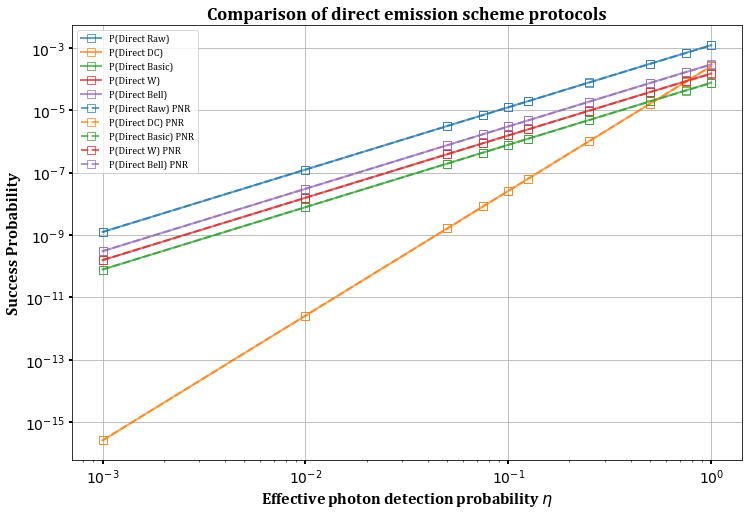

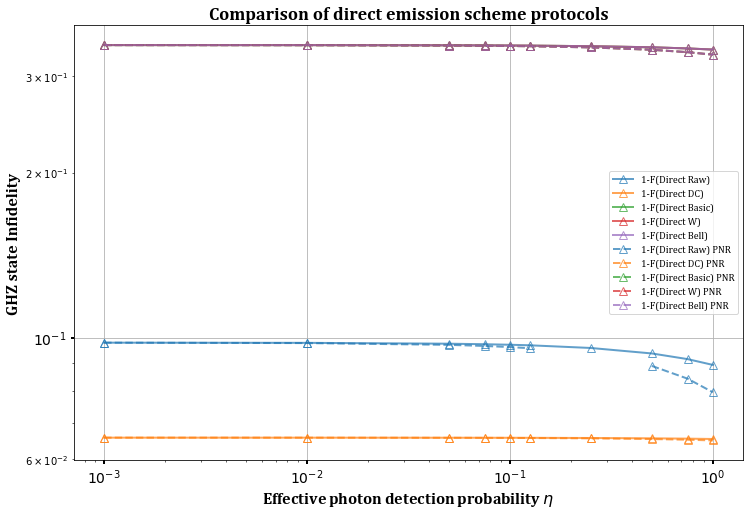

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from circuit_simulation.circuit_simulator import QuantumCircuit

# Effective photon detection probability eta
eta = np.array([1e-3, 1e-2, 0.05, 0.075, 1e-1, 0.125, 0.25, 0.5, 0.75, 1.0])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot the curves with specified markers and colors
raw_p = []
raw_inf = []
dc_state_p = []
dc_state_inf = []
basic_state_p = []
basic_state_inf = []
w_state_p = []
w_state_inf = []
bell_distilled_state_p = []
bell_distilled_state_inf = []

pnr_raw_p = []
pnr_raw_inf = []
pnr_dc_state_p = []
pnr_dc_state_inf = []
pnr_basic_state_p = []
pnr_basic_state_inf = []
pnr_w_state_p = []
pnr_w_state_inf = []
pnr_bell_distilled_state_p = []
pnr_bell_distilled_state_inf = []

for eta_val in eta:
    print(f"eta:{eta_val}")
    bell_pair_parameters = {"ent_prot": "double_click", "F_prep": 0.999, "p_DE": 0.01, "mu": 0.95, "lambda": 1, "eta": eta_val, "alpha": 0.02}
    
    raw_state_qc = QuantumCircuit(1, network_noise_type=100, bell_pair_parameters=bell_pair_parameters, T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    raw_p.append(raw_state_qc.p_link)
    raw_inf.append(1-raw_state_qc.F_link)
    
    dc_state_qc = QuantumCircuit(1, network_noise_type=101, bell_pair_parameters=bell_pair_parameters, T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    dc_state_p.append(dc_state_qc.p_link)
    dc_state_inf.append(1-dc_state_qc.F_link)
    
    basic_distilled_state_qc = QuantumCircuit(1, network_noise_type=103, bell_pair_parameters=bell_pair_parameters, T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    basic_state_p.append(basic_distilled_state_qc.p_link)
    basic_state_inf.append(1-basic_distilled_state_qc.F_link)
    
    w_distilled_state_qc = QuantumCircuit(1, network_noise_type=104, bell_pair_parameters=bell_pair_parameters, T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    w_state_p.append(w_distilled_state_qc.p_link)
    w_state_inf.append(1-w_distilled_state_qc.F_link)
    
    bell_distilled_state_qc = QuantumCircuit(1, network_noise_type=102, bell_pair_parameters=bell_pair_parameters, T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    bell_distilled_state_p.append(bell_distilled_state_qc.p_link)
    bell_distilled_state_inf.append(1-bell_distilled_state_qc.F_link)

    # PNR scenario
    raw_state_qc_pnr = QuantumCircuit(1, network_noise_type=100, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters, T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    pnr_raw_p.append(raw_state_qc_pnr.p_link)
    pnr_raw_inf.append(1-raw_state_qc_pnr.F_link)
    
    dc_state_qc_pnr = QuantumCircuit(1, network_noise_type=101, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters, T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    pnr_dc_state_p.append(dc_state_qc_pnr.p_link)
    pnr_dc_state_inf.append(1-dc_state_qc_pnr.F_link)
    
    basic_distilled_state_qc_pnr = QuantumCircuit(1, network_noise_type=103, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters, T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    pnr_basic_state_p.append(basic_distilled_state_qc_pnr.p_link)
    pnr_basic_state_inf.append(1-basic_distilled_state_qc_pnr.F_link)
    
    w_distilled_state_qc_pnr = QuantumCircuit(1, network_noise_type=104, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters, T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    pnr_w_state_p.append(w_distilled_state_qc_pnr.p_link)
    pnr_w_state_inf.append(1-w_distilled_state_qc_pnr.F_link)
    
    bell_distilled_state_qc_pnr = QuantumCircuit(1, network_noise_type=102, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters, T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
    pnr_bell_distilled_state_p.append(bell_distilled_state_qc_pnr.p_link)
    pnr_bell_distilled_state_inf.append(1-bell_distilled_state_qc_pnr.F_link)

ax.plot(eta, raw_p, marker='s', color='#1f77b4', label='P(Direct Raw)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax.plot(eta, dc_state_p, marker='s', color='#ff7f0e', label='P(Direct DC)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax.plot(eta, basic_state_p, marker='s', color='#2ca02c', label='P(Direct Basic)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax.plot(eta, w_state_p, marker='s', color='#d62728', label='P(Direct W)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax.plot(eta, bell_distilled_state_p, marker='s', color='#9467bd', label='P(Direct Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple

ax.plot(eta, pnr_raw_p, marker='s', color='#1f77b4', label='P(Direct Raw) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax.plot(eta, pnr_dc_state_p, marker='s', color='#ff7f0e', label='P(Direct DC) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax.plot(eta, pnr_basic_state_p, marker='s', color='#2ca02c', label='P(Direct Basic) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax.plot(eta, pnr_w_state_p, marker='s', color='#d62728', label='P(Direct W) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax.plot(eta, pnr_bell_distilled_state_p, marker='s', color='#9467bd', label='P(Direct Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple

# Enable grid
ax.grid(True)

# Set y-axis to log scale
ax.set_yscale('log')
ax.set_xscale('log')

# Set bold axis ticks and labels
ax.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax.set_xlabel(r'Effective photon detection probability $\eta$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax.set_ylabel('Success Probability', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax.set_title('Comparison of direct emission scheme protocols', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

## INFIDELITY PLOTS

fig_2, ax_2 = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig_2.patch.set_facecolor('white')
ax_2.set_facecolor('white')

# Plot the curves with specified markers and colors
ax_2.plot(eta, raw_inf, marker='^', color='#1f77b4', label='1-F(Direct Raw)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax_2.plot(eta, dc_state_inf, marker='^', color='#ff7f0e', label='1-F(Direct DC)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax_2.plot(eta, basic_state_inf, marker='^', color='#2ca02c', label='1-F(Direct Basic)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax_2.plot(eta, w_state_inf, marker='^', color='#d62728', label='1-F(Direct W)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax_2.plot(eta, bell_distilled_state_inf, marker='^', color='#9467bd', label='1-F(Direct Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple

ax_2.plot(eta, pnr_raw_inf, marker='^', color='#1f77b4', label='1-F(Direct Raw) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax_2.plot(eta, pnr_dc_state_inf, marker='^', color='#ff7f0e', label='1-F(Direct DC) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax_2.plot(eta, pnr_basic_state_inf, marker='^', color='#2ca02c', label='1-F(Direct Basic) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax_2.plot(eta, pnr_w_state_inf, marker='^', color='#d62728', label='1-F(Direct W) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax_2.plot(eta, pnr_bell_distilled_state_inf, marker='^', color='#9467bd', label='1-F(Direct Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple

# Enable grid
ax_2.grid(True)

# Set y-ax_2is to log scale
ax_2.set_yscale('log')
ax_2.set_xscale('log')

# Set bold ax_2is ticks and labels
ax_2.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax_2.set_xlabel(r'Effective photon detection probability $\eta$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.set_ylabel('GHZ state Infidelity', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax_2.set_title('Comparison of direct emission scheme protocols', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize



# Show the plot
plt.show()


## Bright state preparation parameters for raw and distillation resource

alpha:0.0010101, alpha_distill:0.0010101
*** GHZ state fidelity of the Bell distillation protocol state is 0.6714680120000862.***
*** Success probability of the Bell distillation protocol state is 1.6045650716016647e-07.***
*** GHZ state fidelity of the Basic protocol state is 0.6714680387346303.***
*** Success probability of the Basic protocol state is 4.0142649253940836e-08.***
*** GHZ state fidelity of the W-state protocol state is 0.6714680180307693.***
*** Success probability of the W-state protocol state is 8.025671702178481e-08.***
alpha:0.0010101, alpha_distill:0.1010101
*** GHZ state fidelity of the Bell distillation protocol state is 0.6714680143519459.***
*** Success probability of the Bell distillation protocol state is 1.605693848678935e-07.***
*** GHZ state fidelity of the Basic protocol state is 0.6714680372750005.***
*** Success probability of the Basic protocol state is 8.027690809075432e-08.***
*** GHZ state fidelity of the W-state protocol state is 0.6714680198034038

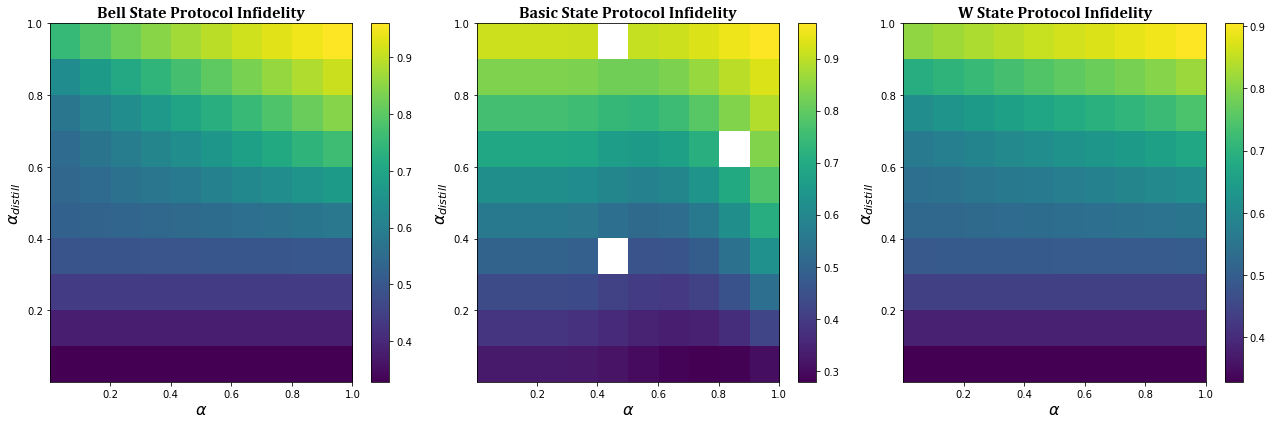

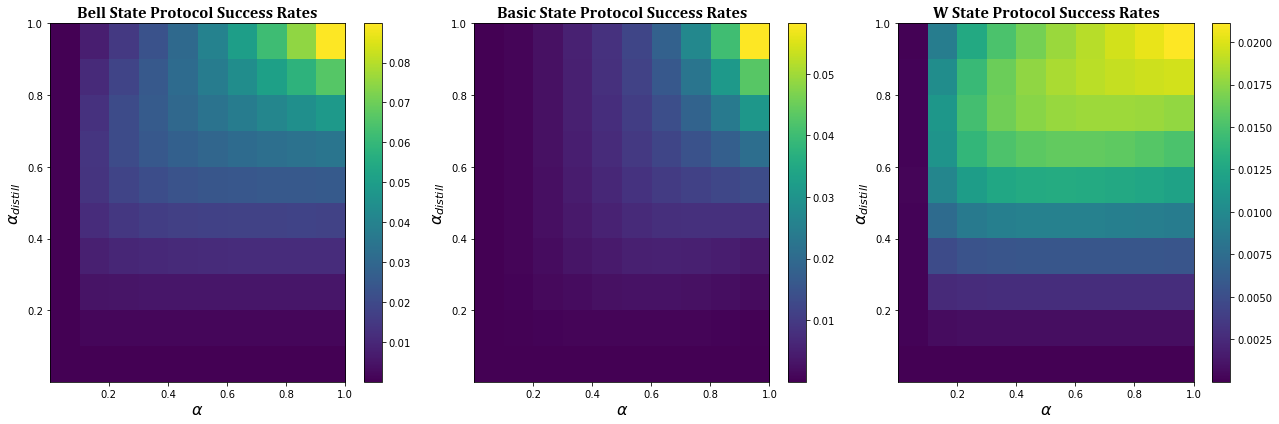

In [ ]:
import numpy as np
from circuit_simulation.circuit_simulator import QuantumCircuit
import matplotlib.pyplot as plt

# Define the range for alpha and alpha_distill
alpha_range = np.arange(0.0010101, 1, 0.1)
alpha_distill_range = np.arange(0.0010101, 1, 0.1)

# Initialize matrices to store infidelity and success probability values
infidelity_bell = np.zeros((len(alpha_range), len(alpha_distill_range)))
infidelity_basic = np.zeros((len(alpha_range), len(alpha_distill_range)))
infidelity_w = np.zeros((len(alpha_range), len(alpha_distill_range)))

success_bell = np.zeros((len(alpha_range), len(alpha_distill_range)))
success_basic = np.zeros((len(alpha_range), len(alpha_distill_range)))
success_w = np.zeros((len(alpha_range), len(alpha_distill_range)))

# Loop over the ranges and compute infidelity and success probability
for i, alpha in enumerate(alpha_range):
    for j, alpha_distill in enumerate(alpha_distill_range):
        print(f"alpha:{alpha}, alpha_distill:{alpha_distill}")
        bell_pair_parameters = {"ent_prot": "single_click", "F_prep": 0.999, "p_DE": 0.01, "mu": 0.95, "lambda": 1, "eta": 0.4474, "alpha": alpha}
        
        # Bell state protocol
        bell_distilled_state_qc = QuantumCircuit(1, network_noise_type=102, alpha_distill=alpha_distill, bell_pair_parameters=bell_pair_parameters, T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
        infidelity_bell[i, j] = 1 - bell_distilled_state_qc.F_link
        success_bell[i, j] = bell_distilled_state_qc.p_link
        
        # Basic state protocol
        basic_distilled_state_qc = QuantumCircuit(1, network_noise_type=103, alpha_distill=alpha_distill, bell_pair_parameters=bell_pair_parameters, T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
        infidelity_basic[i, j] = 1 - basic_distilled_state_qc.F_link
        success_basic[i, j] = basic_distilled_state_qc.p_link
        
        # W state protocol
        w_distilled_state_qc = QuantumCircuit(1, network_noise_type=104, alpha_distill=alpha_distill, bell_pair_parameters=bell_pair_parameters, T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf)
        infidelity_w[i, j] = 1 - w_distilled_state_qc.F_link
        success_w[i, j] = w_distilled_state_qc.p_link

# Plot the heatmaps for infidelity
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

cmap = 'viridis'

# Bell state protocol heatmap
im1 = axs[0].imshow(infidelity_bell, extent=[0.001, 1, 0.001, 1], origin='lower', aspect='auto', cmap=cmap)
axs[0].set_title('Bell State Protocol Infidelity', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[0].set_xlabel(r'$\alpha_{raw}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[0].set_ylabel(r'$\alpha_{distill}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
fig.colorbar(im1, ax=axs[0])

# Basic state protocol heatmap
im2 = axs[1].imshow(infidelity_basic, extent=[0.001, 1, 0.001, 1], origin='lower', aspect='auto', cmap=cmap)
axs[1].set_title('Basic State Protocol Infidelity', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[1].set_xlabel(r'$\alpha_{raw}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[1].set_ylabel(r'$\alpha_{distill}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
fig.colorbar(im2, ax=axs[1])

# W state protocol heatmap
im3 = axs[2].imshow(infidelity_w, extent=[0.001, 1, 0.001, 1], origin='lower', aspect='auto', cmap=cmap)
axs[2].set_title('W State Protocol Infidelity', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[2].set_xlabel(r'$\alpha_{raw}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[2].set_ylabel(r'$\alpha_{distill}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
fig.colorbar(im3, ax=axs[2])

plt.tight_layout()
plt.show()

# Plot the heatmaps for success probability
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Bell state protocol heatmap
im1 = axs[0].imshow(success_bell, extent=[0.001, 1, 0.001, 1], origin='lower', aspect='auto', cmap=cmap)
axs[0].set_title('Bell State Protocol Success Rates', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[0].set_xlabel(r'$\alpha_{raw}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[0].set_ylabel(r'$\alpha_{distill}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
fig.colorbar(im1, ax=axs[0])

# Basic state protocol heatmap
im2 = axs[1].imshow(success_basic, extent=[0.001, 1, 0.001, 1], origin='lower', aspect='auto', cmap=cmap)
axs[1].set_title('Basic State Protocol Success Rates', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[1].set_xlabel(r'$\alpha_{raw}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[1].set_ylabel(r'$\alpha_{distill}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
fig.colorbar(im2, ax=axs[1])

# W state protocol heatmap
im3 = axs[2].imshow(success_w, extent=[0.001, 1, 0.001, 1], origin='lower', aspect='auto', cmap=cmap)
axs[2].set_title('W State Protocol Success Rates', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[2].set_xlabel(r'$\alpha_{raw}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[2].set_ylabel(r'$\alpha_{distill}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
fig.colorbar(im3, ax=axs[2])

plt.tight_layout()
plt.show()

# Threshold data for direct emission scheme

Reduced chi squared is 2533.274371033828.
Least squared fitting on dataset results:
Threshold = 0.004513854076580802 +- 0.00039986980138172434
A= 0.9289872131757907 B= -16.596784566993772 C= 73.57059984291763
D= -1.9800000000000004 nu= 1.199989783802793 mu= 0.71

Reduced chi-squared for fit equals 2533.274371033828.
0.00039986980138172434
The LSR at threshold (pth): 0.9289872131757907 +- 0.05263418772823669


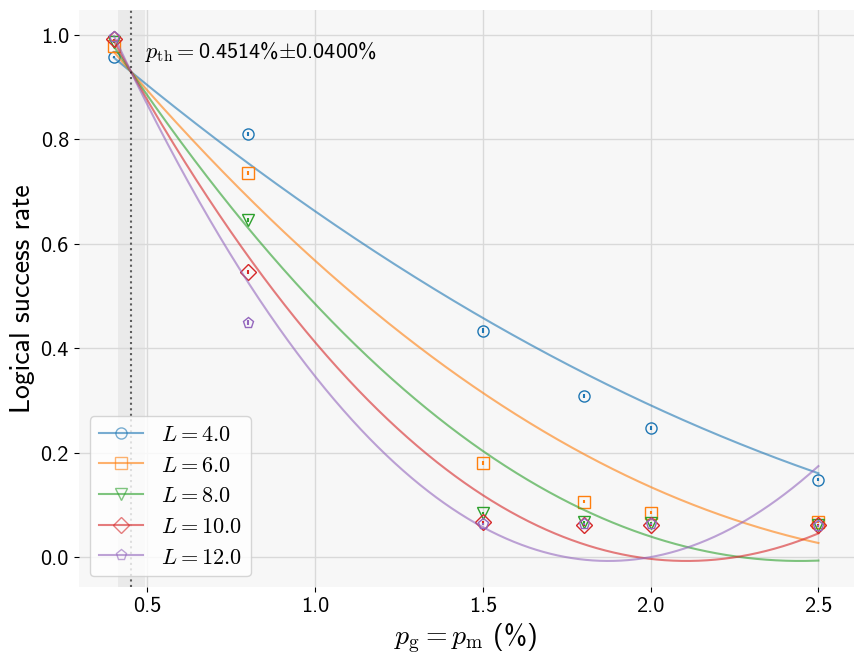

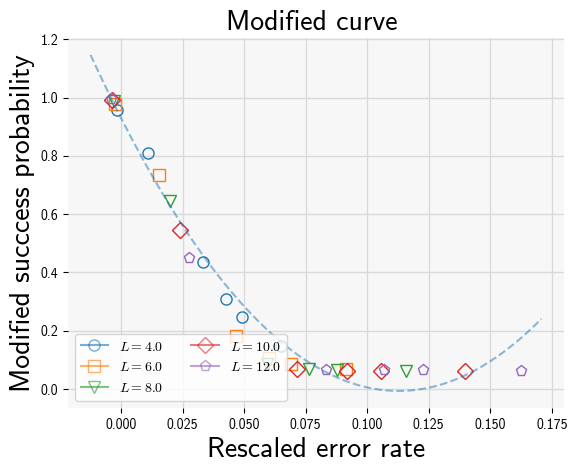

(<Figure size 1000x750 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

In [22]:
import pandas as pd
from oopsc.threshold.plot import plot_thresholds
# import seaborn as sns


### DATA FOR THE THRESHOLDS FOR DIFFERENT CASES ###

# RAW FIRST SIMULATION WITH NO-CUTOFF
# @ INF
# data = {"(4, 4)":{"0":[0.00001,0.14674],"1":[0.0001,0.14974],"2":[0.0005,0.14266],"3":[0.0008,0.13734],"4":[0.001,0.13724],"5":[0.002,0.12682],"6":[0.003,0.11836],"7":[0.004,0.11064]},"(6, 6)":{"0":[0.00001,0.07312],"1":[0.0001,0.0724],"2":[0.0005,0.07142],"3":[0.0008,0.06996],"4":[0.001,0.06756],"5":[0.002,0.06716],"6":[0.003,0.06568],"7":[0.004,0.06592]},"(8, 8)":{"0":[0.00001,0.06322],"1":[0.0001,0.06414],"2":[0.0005,0.0627],"3":[0.0008,0.0632],"4":[0.001,0.06374],"5":[0.002,0.06412],"6":[0.003,0.06404],"7":[0.004,0.06252]},"(10, 10)":{"0":[0.00001,0.06482],"1":[0.0001,0.0612],"2":[0.0005,0.06292],"3":[0.0008,0.0618],"4":[0.001,0.0615],"5":[0.002,0.0628],"6":[0.003,0.06246],"7":[0.004,0.06272]},"(12, 12)":{"0":[0.00001,0.06306],"1":[0.0001,0.06206],"2":[0.0005,0.06212],"3":[0.0008,0.06266],"4":[0.001,0.06216],"5":[0.002,0.06184],"6":[0.003,0.06158],"7":[0.004,0.06222]}}

# BASIC FIRST SIMULATION WITH NO-CUTOFF
# @ INF
# data = {"(4, 4)":{"0":[0.00001,0.9998],"1":[0.0001,0.99982],"2":[0.0005,0.9993],"3":[0.0008,0.99806],"4":[0.001,0.99732],"5":[0.002,0.99064],"6":[0.003,0.97748],"7":[0.004,0.95886]},"(6, 6)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,0.99976],"4":[0.001,0.99974],"5":[0.002,0.99804],"6":[0.003,0.9921],"7":[0.004,0.97586]},"(8, 8)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,1.0],"4":[0.001,0.99994],"5":[0.002,0.99948],"6":[0.003,0.99726],"7":[0.004,0.9865]},"(10, 10)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,1.0],"4":[0.001,1.0],"5":[0.002,0.99992],"6":[0.003,0.99878],"7":[0.004,0.99184]},"(12, 12)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,1.0],"4":[0.001,1.0],"5":[0.002,0.99996],"6":[0.003,0.99958],"7":[0.004,0.99578]}}
data = {"(4, 4)":{"0":[0.004,0.95792],"1":[0.008,0.80982],"2":[0.015,0.43398],"3":[0.018,0.30888],"4":[0.02,0.24822],"5":[0.025,0.14874]},"(6, 6)":{"0":[0.004,0.97788],"1":[0.008,0.7354],"2":[0.015,0.1808],"3":[0.018,0.10596],"4":[0.02,0.08518],"5":[0.025,0.06764]},"(8, 8)":{"0":[0.004,0.98632],"1":[0.008,0.64612],"2":[0.015,0.08508],"3":[0.018,0.06686],"4":[0.02,0.06604],"5":[0.025,0.0619]},"(10, 10)":{"0":[0.004,0.9917],"1":[0.008,0.5464],"2":[0.015,0.06674],"3":[0.018,0.06224],"4":[0.02,0.06272],"5":[0.025,0.061]},"(12, 12)":{"0":[0.004,0.99568],"1":[0.008,0.44886],"2":[0.015,0.06368],"3":[0.018,0.06378],"4":[0.02,0.06434],"5":[0.025,0.06028]}}
# data = {"(4, 4)":{"1":[0.001,0.99744],"2":[0.002,0.98984],"3":[0.003,0.9784],"4":[0.004,0.95926],"5":[0.008,0.8081]},"(6, 6)":{"1":[0.001,0.99978],"2":[0.002,0.99814],"3":[0.003,0.99278],"4":[0.004,0.97702],"5":[0.008,0.73422]},"(8, 8)":{"1":[0.001,0.99996],"2":[0.002,0.99962],"3":[0.003,0.99716],"4":[0.004,0.98624],"5":[0.008,0.648]},"(10, 10)":{"1":[0.001,1.0],"2":[0.002,1.0],"3":[0.003,0.99888],"4":[0.004,0.99244],"5":[0.008,0.54708]},"(12, 12)":{"1":[0.001,1.0],"2":[0.002,0.99998],"3":[0.003,0.99956],"4":[0.004,0.99526],"5":[0.008,0.44674]}}

# MEDIUM FIRST SIMULATION WITH NO-CUTOFF
# @ INF
# data = 


iters = 50000

rates = [rate[0] for rate in list(data["(6, 6)"].values())]

l4 = [rate[1] for rate in list(data["(4, 4)"].values())]
l6 = [rate[1] for rate in list(data["(6, 6)"].values())]
l8 = [rate[1] for rate in list(data["(8, 8)"].values())]
l10 = [rate[1] for rate in list(data["(10, 10)"].values())]
l12 = [rate[1] for rate in list(data["(12, 12)"].values())]

data_frame = pd.DataFrame(columns=["L", "p_g", "N", "success"])

for p_rate, success in zip(rates, l4):
    to_add = [4, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l6):
    to_add = [6, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l8):
    to_add = [8, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l10):
    to_add = [10, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l12):
    to_add = [12, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add


data_frame = data_frame.set_index(["L", "p_g"])
# sns.set(style="darkgrid")
plot_thresholds(data=data_frame,output="example_threshold", modified_ansatz=False, accuracy=None)